In [1]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

prc_filter = 0.125

impl_volatility = 'impl_volatility_h_1_step'

# data = data[data['prc_option'] > prc_filter]
# datat = datat[datat['prc_option'] > prc_filter]

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

# data_sso = data_sso[data_sso['prc_option'] > prc_filter]
# datat_sso = datat_sso[datat_sso['prc_option'] > prc_filter]

# basic = ['moneyness', 'T', 'moneyness_squared', 'tau_squared', 'moneyness_tau']
basic = ['moneyness', 'T']
option_specific = ['cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv']
macro_features = ['2Y_bond','FF_rate', 'gold_price','reces_indi', 'CLOSE_vix', 'hi-lo_vix']
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', "vol_stock", 'RET', 'spread_stock']



tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]
tickers = ['ticker_TSLA', 'ticker_AMZN']

totalList = ['moneyness', 'T'] + macro_features + option_specific + stock_specific + tickers

totalList_standardize = totalList + ['impl_volatility', 'date', 'ticker']

In [35]:
print(data['prc_option'])

421         0.205
422         0.360
423         0.400
424         0.270
425        45.225
           ...   
173367    102.325
173368     98.675
173369     94.650
173370     91.100
173371    110.125
Name: prc_option, Length: 172951, dtype: float64


All Data In-sample RMSE: 0.2600021937257837
All Data In-sample R²: 0.6303975753846274
Daily average errors calculated for 250 days.
Newey-West Standard Error (Based on Daily Averages): 0.007652912696746519
Daily average errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/ols_all.csv
All Data Out-of-sample RMSE: 0.2387387949733694
All Data Out-of-sample R²: 0.5497345842016591


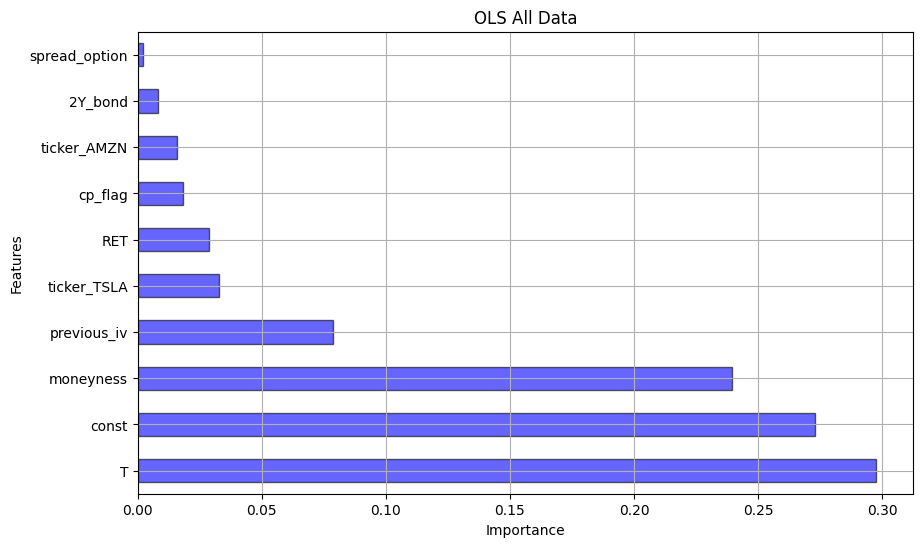

Newey-West Standard Error (All Data): 0.007652912696746519


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_56459/577046086.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ols_model.bse[0]  # Standard error of the constant term


AAPL RMSE: 0.19909128465630116
AAPL R²: -0.3515050975495355


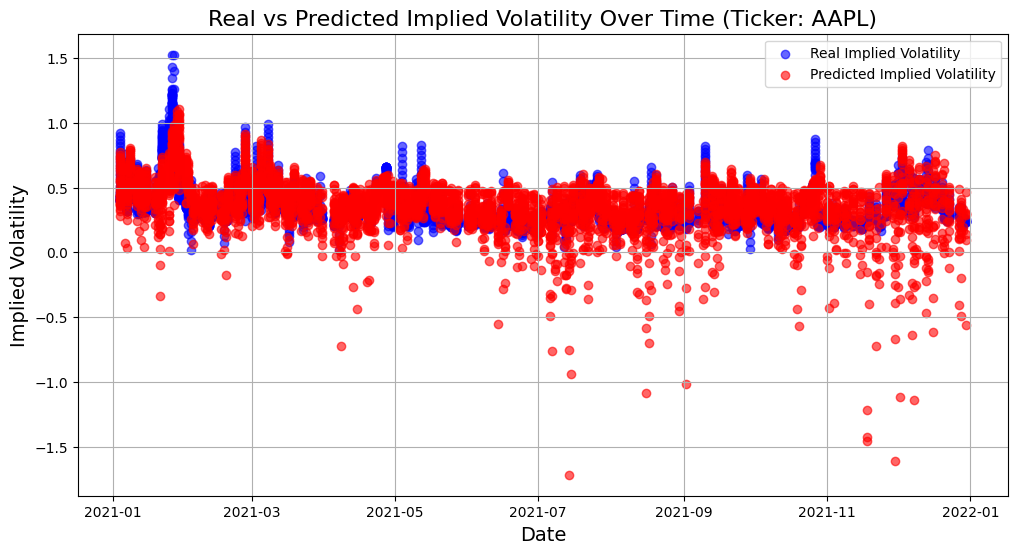

AMZN RMSE: 0.22004471573426856
AMZN R²: 0.23657177160713594


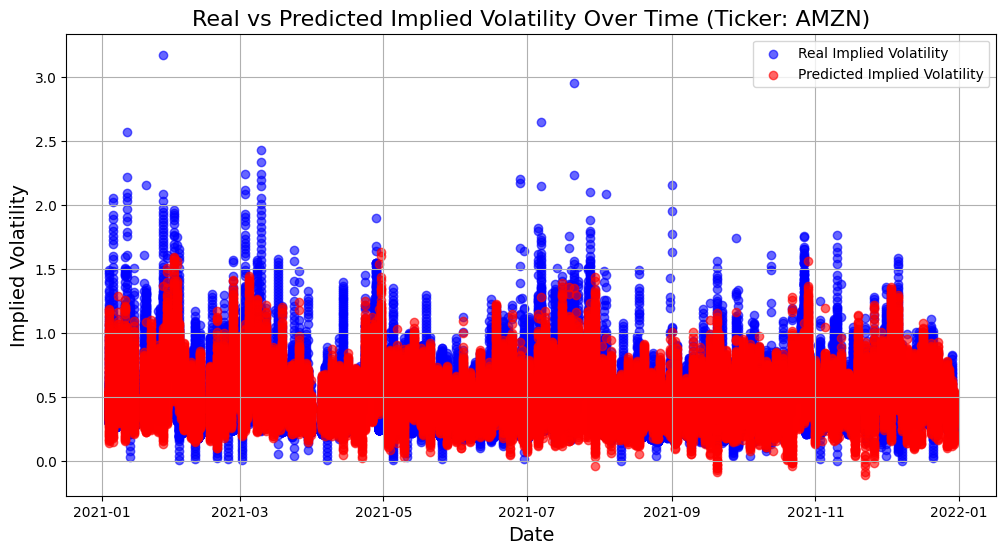

NVDA RMSE: 0.2673922115664492
NVDA R²: 0.28061107376328254


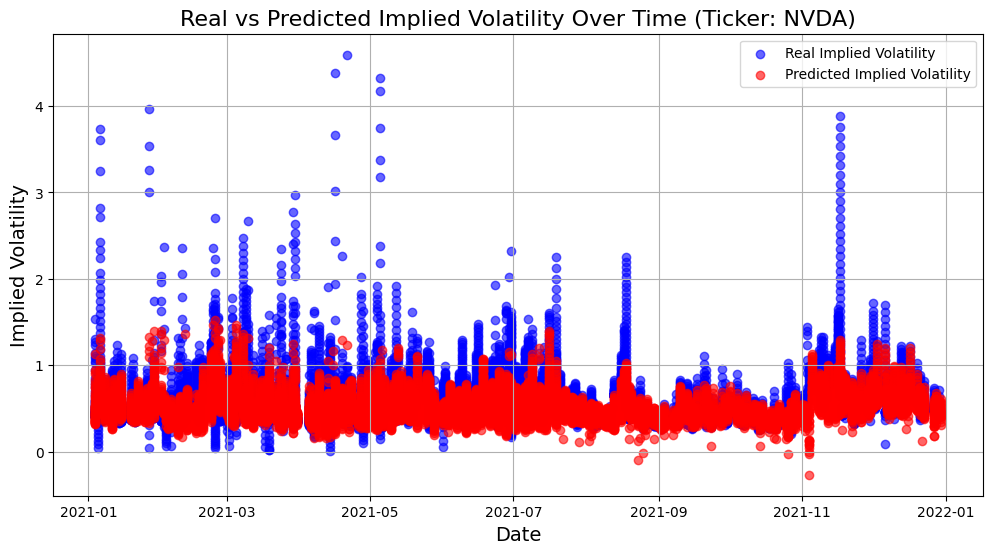

TSLA RMSE: 0.29306894088796265
TSLA R²: 0.5477519183330133


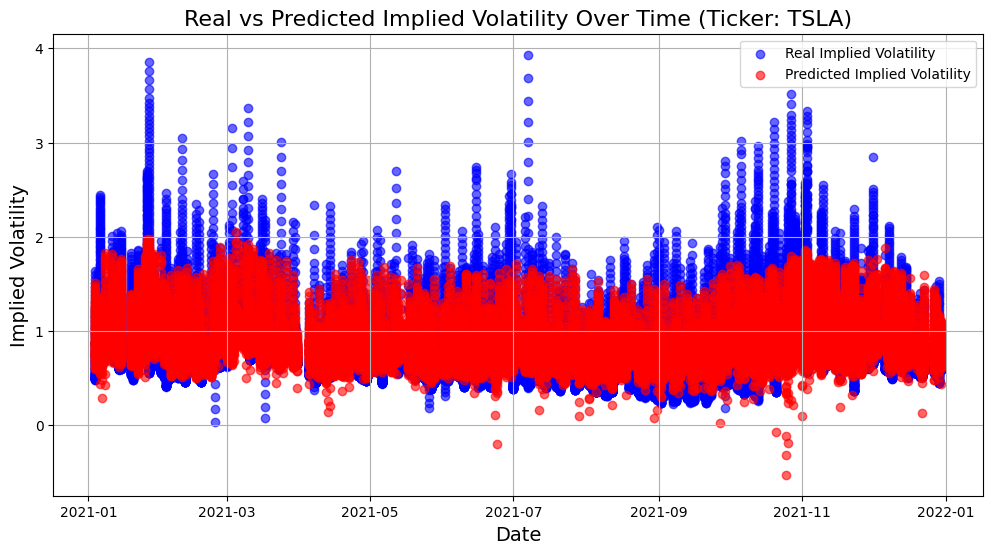

META RMSE: 0.16662004405922093
META R²: 0.313815226620878


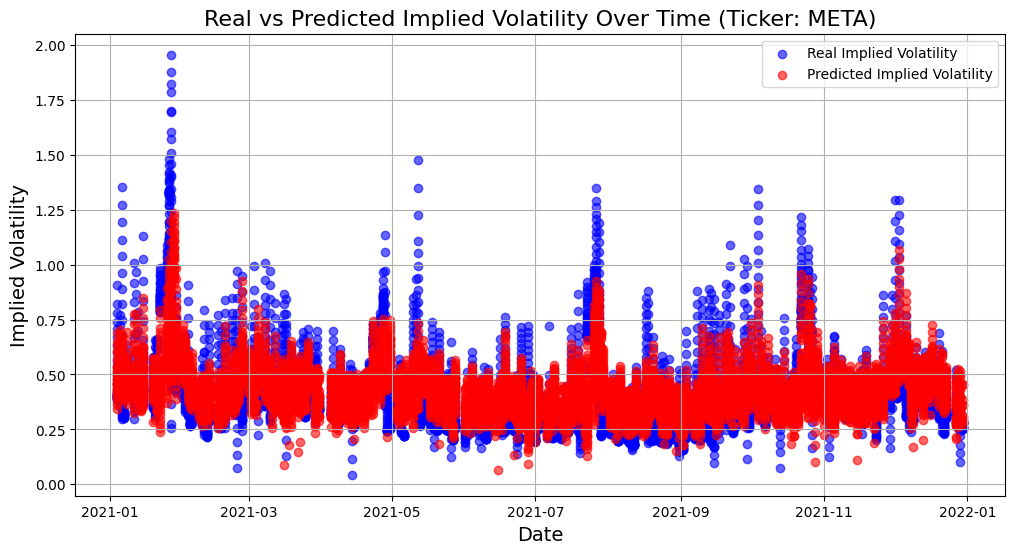

MSFT RMSE: 0.14403106462792817
MSFT R²: -0.05957903121165442


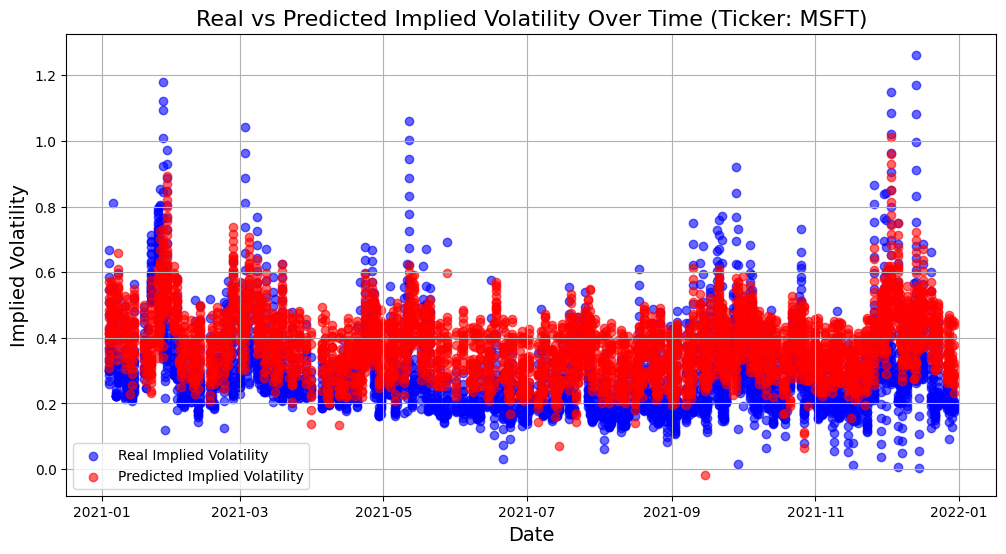

Overall Weighted RMSE: 0.2387387949733694
Overall Weighted R²: 0.28014668324643555


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

def run_ols(data, datat, title):
    """Runs OLS regression, calculates RMSE and R², and returns the top 10 most important features, normalized."""
    # Prepare the training data
    y_train = data[impl_volatility]
    X_train = data[totalList]
    X_train = sm.add_constant(X_train) # Add a constant for intercept

    # Fit the OLS model on the training data
    model = sm.OLS(y_train, X_train).fit()

    # Predict on the in-sample (training) data
    y_train_pred = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    print(f'{title} In-sample RMSE: {rmse_train}')
    print(f'{title} In-sample R²: {r2_train}')

    # Prepare the test data (out-of-sample)
    y_test = datat[impl_volatility]
    X_test = datat[totalList]
    X_test = sm.add_constant(X_test)

    # Predict on the test data
    y_test_pred = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)

    # Calculate Newey-West standard error
    # Example calculation
    errors_test = y_test - y_test_pred
    datat['Errors'] = errors_test  # Add errors to the test dataset

    # Group errors by date and calculate daily averages
    if 'date' in datat.columns:
        daily_avg_errors = datat.groupby('date')['Errors'].mean()
        print(f"Daily average errors calculated for {len(daily_avg_errors)} days.")
    else:
        raise ValueError("The dataset does not contain a 'date' column.")

    # Calculate Newey-West standard error using daily averages
    nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error_test}")

    # Save the daily errors and Newey-West standard error into a CSV
    file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/ols_all.csv'

    # Create a DataFrame with daily averaged errors and repeated Newey-West standard error
    dm_test_data = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
    })

    # Save the DataFrame to a CSV
    dm_test_data.to_csv(file_path, index=False)
    print(f"Daily average errors and Newey-West statistics saved to {file_path}")

    print(f'{title} Out-of-sample RMSE: {rmse_test}')
    print(f'{title} Out-of-sample R²: {r2_test}')

    # Create feature importance plot
    coefs = model.params.drop('const')
    coefs = model.params
    importance = coefs.abs() / coefs.abs().sum()
    top_10_features = importance.sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    ax = top_10_features.plot(kind='barh', color='blue', alpha=0.6, edgecolor='black', linewidth=1)
    plt.grid(True)
    ax.set_title(f'OLS {title}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    plt.show()

    return model, top_10_features, daily_avg_errors

def calculate_weighted_metrics(datat, model, totalList):
    """Calculates weighted RMSE and R² for each ticker and overall across all tickers."""
    results_list_all = []
    unique_tickers = datat['Ticker'].unique()

    total_rmse_weighted_sum = 0
    total_r2_weighted_sum = 0
    total_observations = 0

    for ticker in unique_tickers:
        # Filter data for current ticker and prepare for prediction
        data_ticker = datat[datat['Ticker'] == ticker]
        y_ticker_actual = data_ticker[impl_volatility]
        X_ticker = data_ticker[totalList]
        X_ticker.insert(0, 'const', 1)  # Add a constant term

        # Predict and calculate RMSE and R² for the ticker
        y_ticker_pred = model.predict(X_ticker)
        rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
        r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)
        num_observations = len(y_ticker_actual)

        # Weighted summing for overall RMSE and R²
        total_rmse_weighted_sum += num_observations * rmse_ticker**2
        total_r2_weighted_sum += num_observations * r2_ticker
        total_observations += num_observations

        results_list_all.append({
            'Ticker': ticker,
            'RMSE': rmse_ticker,
            'R²': r2_ticker
        })

        print(f'{ticker} RMSE: {rmse_ticker}')
        print(f'{ticker} R²: {r2_ticker}')

        plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

    # Calculate overall weighted RMSE and R²
    overall_rmse = np.sqrt(total_rmse_weighted_sum / total_observations)
    overall_r2 = total_r2_weighted_sum / total_observations

    print(f'Overall Weighted RMSE: {overall_rmse}')
    print(f'Overall Weighted R²: {overall_r2}')

    return {
        'Ticker_Results': results_list_all,
        'Overall_RMSE': overall_rmse,
        'Overall_R²': overall_r2
    }

# Run OLS model for all data and calculate weighted metrics
model, top_10_features, errors_all = run_ols(data, datat, "All Data")

# Calculate Newey-West standard error for the entire dataset
nw_std_error_all = newey_west_standard_error(errors_all, lag=1)
print(f"Newey-West Standard Error (All Data): {nw_std_error_all}")

weighted_metrics = calculate_weighted_metrics(datat, model, totalList)

# # Print the top 10 features with importance values
# print("Top 10 Features (Feature, Importance):")
# print(top_10_features)

# # Print overall weighted RMSE and R²
# print(f"Overall Weighted RMSE: {weighted_metrics['Overall_RMSE']}")
# print(f"Overall Weighted R²: {weighted_metrics['Overall_R²']}")


In [3]:
model.params

const                          -1.507210e+00
moneyness                       1.543326e+00
T                               2.078433e+00
2Y_bond                         5.200477e-02
FF_rate                        -3.465407e-03
gold_price                      4.254650e-04
reces_indi                      4.666202e-03
CLOSE_vix                       3.372513e-03
hi-lo_vix                       4.261000e-03
cp_flag                         1.173993e-01
spread_option                  -1.253410e-02
volume                         -3.574876e-06
prc_option                     -1.416572e-03
previous_iv                     4.827377e-01
BID                             3.710731e-04
ASK                            -3.886888e-04
daily_return_indicator_stock   -6.901067e-03
hi-lo_stock                     5.038583e-04
PRC                             8.625443e-05
vol_stock                       1.082850e-09
RET                             1.810044e-01
spread_stock                   -7.597620e-04
ticker_AAP

Baseline R² (OOS): 0.5497
Feature: moneyness, Baseline R²: 0.5497, Perturbed R²: -19.2198, Absolute Change: 19.7695
Feature: T, Baseline R²: 0.5497, Perturbed R²: 0.5509, Absolute Change: 0.0012
Feature: 2Y_bond, Baseline R²: 0.5497, Perturbed R²: 0.5536, Absolute Change: 0.0038
Feature: FF_rate, Baseline R²: 0.5497, Perturbed R²: 0.5495, Absolute Change: 0.0002
Feature: gold_price, Baseline R²: 0.5497, Perturbed R²: -0.0203, Absolute Change: 0.5701
Feature: reces_indi, Baseline R²: 0.5497, Perturbed R²: 0.5488, Absolute Change: 0.0009
Feature: CLOSE_vix, Baseline R²: 0.5497, Perturbed R²: 0.5463, Absolute Change: 0.0035
Feature: hi-lo_vix, Baseline R²: 0.5497, Perturbed R²: 0.5575, Absolute Change: 0.0078
Feature: cp_flag, Baseline R²: 0.5497, Perturbed R²: 0.5191, Absolute Change: 0.0306
Feature: spread_option, Baseline R²: 0.5497, Perturbed R²: 0.5441, Absolute Change: 0.0056
Feature: volume, Baseline R²: 0.5497, Perturbed R²: 0.5380, Absolute Change: 0.0117
Feature: prc_option, Bas

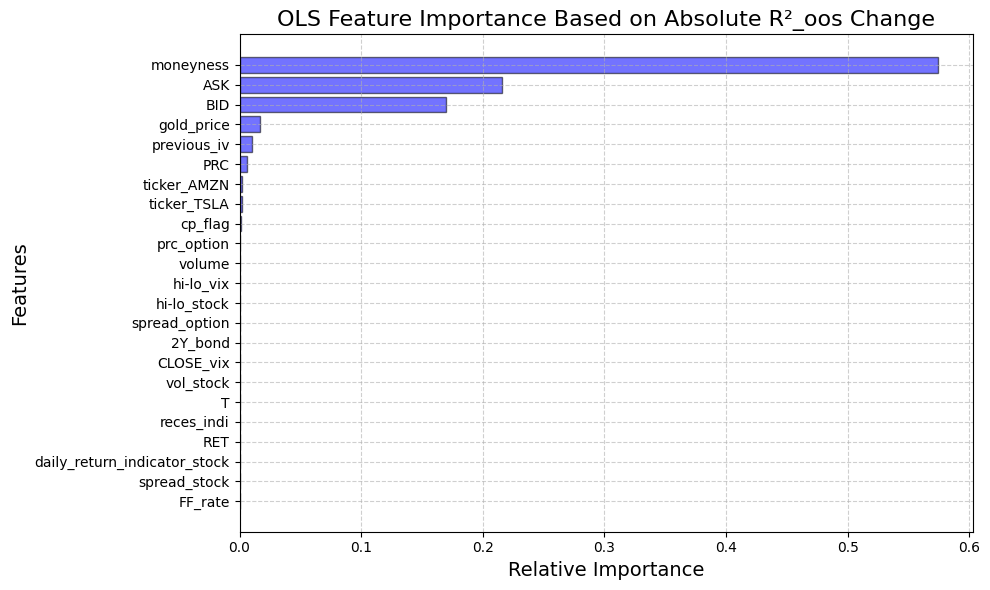

In [3]:
def calculate_feature_importance_r2_ols(data_train, data_test, features, target):
    """
    Calculate feature importance for OLS based on the absolute change in R²_oos when a feature is set to zero.

    Parameters:
    - data_train: Training dataset
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (e.g., implied volatility)
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    - baseline_r2: Baseline R²_oos value.
    """
    # Train the OLS model
    y_train = data_train[target]
    X_train = data_train[features]
    X_train = sm.add_constant(X_train)  # Add constant for intercept

    model = sm.OLS(y_train, X_train).fit()

    # Calculate baseline R²_oos
    y_test = data_test[target]
    X_test = data_test[features]
    X_test = sm.add_constant(X_test)

    y_test_pred = model.predict(X_test)
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate the absolute change in R²_oos for each feature
    r2_changes = []
    for feature in features:
        # Perturb the test data by setting the feature to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[feature] = 0

        # Predict and calculate R²_oos
        y_test_pred_zeroed = model.predict(X_test_zeroed)
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_change = abs(baseline_r2 - r2_zeroed)  # Use absolute change
        r2_changes.append(r2_change)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Absolute Change: {r2_change:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_changes)
    if r2_importance.sum() > 0:
        r2_importance = r2_importance / r2_importance.sum()  # Normalize to sum to 1
    else:
        r2_importance = np.zeros_like(r2_importance)  # Handle edge case where all changes are zero

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2


def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Example Usage: Calculate feature importance for OLS
feature_importance_ols, baseline_r2 = calculate_feature_importance_r2_ols(
    data_train=data,
    data_test=datat,
    features=totalList,
    target=impl_volatility
)

# Print and visualize the feature importance
print("Feature Importance (Absolute R²_oos Change):")
print(feature_importance_ols)

plot_feature_importance(feature_importance_ols, title="OLS Feature Importance Based on Absolute R²_oos Change")


In [6]:
# feature_importance_ols["Importance"].tolist()
feature_importance_ols["Feature"].tolist()

['moneyness',
 'ASK',
 'BID',
 'ticker_AMZN',
 'gold_price',
 'previous_iv',
 'PRC',
 'ticker_MSFT',
 'ticker_META',
 'ticker_AAPL',
 'cp_flag',
 'ticker_NVDA',
 'prc_option',
 'volume',
 'hi-lo_vix',
 'CLOSE_vix',
 'vol_stock',
 'hi-lo_stock',
 'spread_option',
 'ticker_TSLA',
 '2Y_bond',
 'reces_indi',
 'RET',
 'daily_return_indicator_stock',
 'T',
 'spread_stock',
 'FF_rate']

In [51]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def run_ols(train_data, test_data, title):
    """Runs OLS regression on 'train_data', evaluates out-of-sample on 'test_data', calculates RMSE and R²."""

    # Prepare the training data
    y_train = train_data[impl_volatility]
    X_train = train_data[totalList]
    X_train = sm.add_constant(X_train)

    # Fit the OLS model on the training data
    model = sm.OLS(y_train, X_train).fit()

    # Predict on the in-sample (training) data
    y_train_pred = model.predict(X_train)

    # Calculate RMSE and R² for in-sample data
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    print(f'{title} In-sample RMSE: {rmse_train}')
    print(f'{title} In-sample R²: {r2_train}')

    # Prepare the test data (out-of-sample)
    y_test = test_data[impl_volatility]
    X_test = test_data[totalList]
    X_test = sm.add_constant(X_test)

    # Predict on the out-of-sample (test) data using the fitted model
    y_test_pred = model.predict(X_test)

    # Calculate RMSE and R² for out-of-sample data
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    print(f'{title} Out-of-sample RMSE: {rmse_test}')
    print(f'{title} Out-of-sample R²: {r2_test}')

    return model, rmse_train, r2_train, rmse_test, r2_test

# Initialize variables to store weighted sums
weighted_rmse_train_sum = 0
weighted_r2_train_sum = 0
weighted_rmse_test_sum = 0
weighted_r2_test_sum = 0
total_train_rows = 0
total_test_rows = 0

## Initialize list to store individual ticker results
results_list_sso = []

# Run OLS for each unique ticker and store the results
results = {}
unique_tickers = data['Ticker'].unique()

for ticker in unique_tickers:
    # Filter the data for the current ticker
    train_data = data[data['Ticker'] == ticker]
    test_data = datat[datat['Ticker'] == ticker]
    # Split the data into training and testing sets (80% train, 20% test)

    # Run OLS for the current ticker
    model_ticker, rmse_train, r2_train, rmse_test, r2_test = run_ols(train_data, test_data, ticker)
    results[ticker] = {
        'model': model_ticker
    }

    # Calculate the number of rows in the training and test sets for the current ticker
    num_train_rows = len(train_data)
    num_test_rows = len(test_data)

    # Update weighted sums for in-sample RMSE and R²
    weighted_rmse_train_sum += rmse_train * num_train_rows
    weighted_r2_train_sum += r2_train * num_train_rows
    total_train_rows += num_train_rows

    # Update weighted sums for out-of-sample RMSE and R²
    weighted_rmse_test_sum += rmse_test * num_test_rows
    weighted_r2_test_sum += r2_test * num_test_rows
    total_test_rows += num_test_rows

    # Save individual ticker results in the list
    results_list_sso.append({
        'Ticker': ticker,
        'RMSE': rmse_test,
        'R²': r2_test
    })




# Calculate weighted averages for in-sample RMSE and R²
weighted_avg_rmse_train = weighted_rmse_train_sum / total_train_rows
weighted_avg_r2_train = weighted_r2_train_sum / total_train_rows

# Calculate weighted averages for out-of-sample RMSE and R²
weighted_avg_rmse_test = weighted_rmse_test_sum / total_test_rows
weighted_avg_r2_test = weighted_r2_test_sum / total_test_rows

print(f'Weighted Average In-sample RMSE: {weighted_avg_rmse_train}')
print(f'Weighted Average In-sample R²: {weighted_avg_r2_train}')
print(f'Weighted Average Out-of-sample RMSE: {weighted_avg_rmse_test}')
print(f'Weighted Average Out-of-sample R²: {weighted_avg_r2_test}')


AMZN In-sample RMSE: 0.24390103085991344
AMZN In-sample R²: 0.37399516961113743
AMZN Out-of-sample RMSE: 0.2278212011000977
AMZN Out-of-sample R²: 0.18165845187036245
META In-sample RMSE: 0.2273059469540719
META In-sample R²: 0.48897056523952254
META Out-of-sample RMSE: 0.17003424613609688
META Out-of-sample R²: 0.2854059639487151
MSFT In-sample RMSE: 0.1720687338783912
MSFT In-sample R²: 0.671926303200684
MSFT Out-of-sample RMSE: 0.11638522998186392
MSFT Out-of-sample R²: 0.3081423432061653
TSLA In-sample RMSE: 0.3495802130581267
TSLA In-sample R²: 0.5783314323215112
TSLA Out-of-sample RMSE: 0.2973756127322318
TSLA Out-of-sample R²: 0.5343626129926509
AAPL In-sample RMSE: 0.15914116110479953
AAPL In-sample R²: 0.5900331631755436
AAPL Out-of-sample RMSE: 0.14972962128108214
AAPL Out-of-sample R²: 0.235585982386175
NVDA In-sample RMSE: 0.26271244865425725
NVDA In-sample R²: 0.4397554999605816
NVDA Out-of-sample RMSE: 0.2573957612749889
NVDA Out-of-sample R²: 0.33339429927235265
Weighted

In [ ]:
datat

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,total_iv_weighted,previous_iv,previous_iv_all,ticker_AAPL,ticker_AMZN,ticker_META,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker
258437,2021-01-04,1,300000,0.06,0.07,1332,2329,0.470726,0.014127,0.002717,...,40.755457,0.314286,0.492815,0,0,1,0,0,0,META
258438,2021-01-04,0,600000,0.78,0.80,6829,7522,0.992547,-0.026374,0.000807,...,5354.701736,0.594084,0.492815,0,0,0,0,0,1,TSLA
258439,2021-01-04,1,302500,0.05,0.06,151,504,0.490299,0.011724,0.002220,...,4.071933,0.314286,0.492815,0,0,1,0,0,0,META
258440,2021-01-04,1,305000,0.04,0.05,132,1656,0.506814,0.009497,0.001788,...,3.010475,0.314286,0.492815,0,0,1,0,0,0,META
258441,2021-01-04,0,602500,0.79,0.89,158,296,0.985023,-0.028028,0.000855,...,130.732253,0.594084,0.492815,0,0,0,0,0,1,TSLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409632,2021-12-30,0,2500000,0.00,0.01,1,534,1.531245,-0.000080,0.000001,...,0.007656,0.240373,0.466017,0,1,0,0,0,0,AMZN
409633,2021-12-30,0,2350000,0.00,0.05,12,120,2.027595,-0.000272,0.000003,...,0.608279,0.240373,0.466017,0,1,0,0,0,0,AMZN
409634,2021-12-30,0,2300000,0.00,0.01,30,230,1.934408,-0.000064,0.000001,...,0.290161,0.240373,0.466017,0,1,0,0,0,0,AMZN
409635,2021-12-30,0,3190000,0.12,0.33,95,863,0.448414,-0.008460,0.000291,...,9.584849,0.240373,0.466017,0,1,0,0,0,0,AMZN


In [ ]:
results_list_sso

[{'Ticker': 'AMZN', 'RMSE': 0.2215907923964439, 'R²': 0.42963391007075247},
 {'Ticker': 'AAPL', 'RMSE': 0.23181520860858362, 'R²': 0.5145893824932946},
 {'Ticker': 'NVDA', 'RMSE': 0.2833792843609984, 'R²': 0.45111591740719437},
 {'Ticker': 'TSLA', 'RMSE': 0.28356663922953634, 'R²': 0.6149205101171088},
 {'Ticker': 'META', 'RMSE': 0.22937936599553427, 'R²': 0.5593223336577444},
 {'Ticker': 'MSFT', 'RMSE': 0.20558987664839676, 'R²': 0.5749042991431725}]

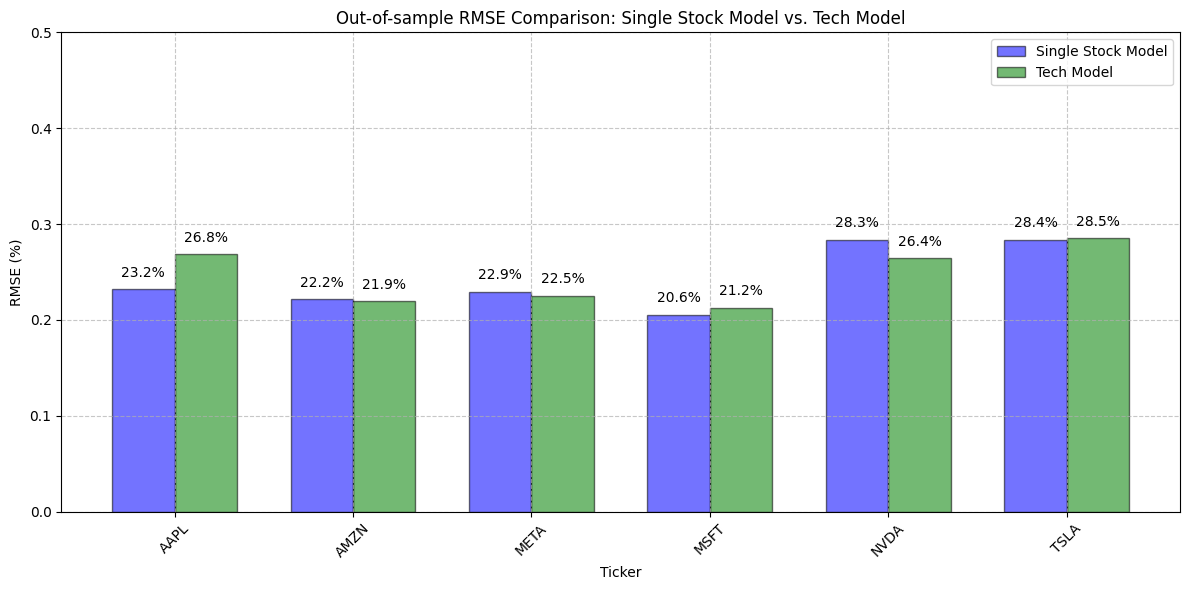

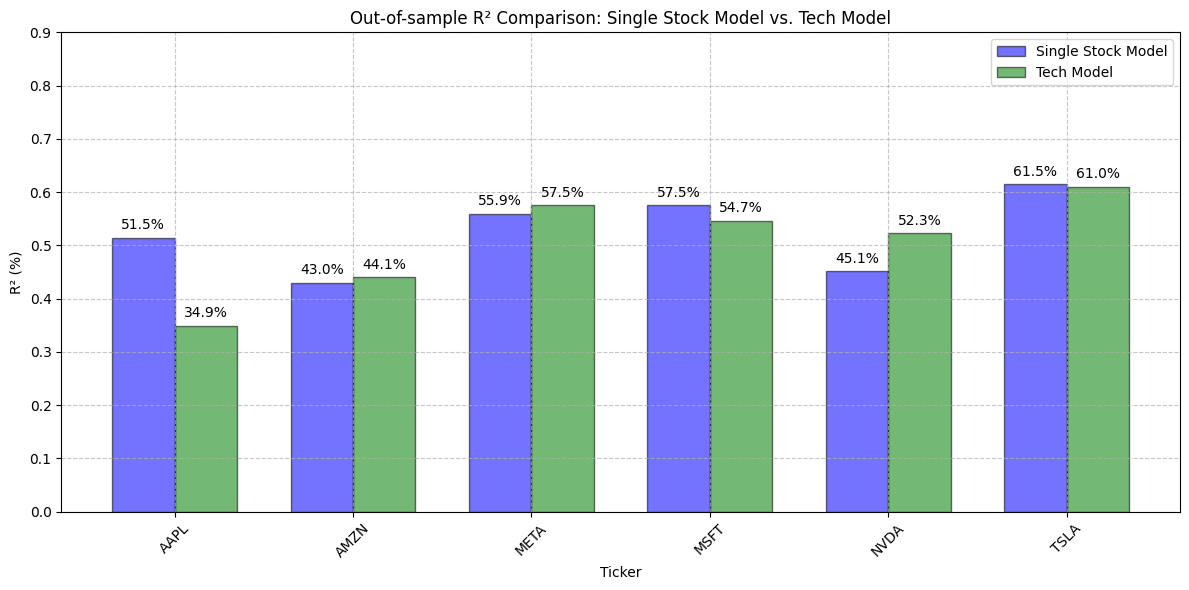

In [ ]:
# Convert lists to DataFrames for easier plotting
results_list_sso_df = pd.DataFrame(results_list_sso).set_index('Ticker').sort_index()
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_sso_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_sso_rmse = plt.bar(x - width/2, results_list_sso_df['RMSE'], width=width, label='Single Stock Model', color='blue', alpha=0.55, edgecolor='black')
bars_all_rmse = plt.bar(x + width/2, results_list_all_df['RMSE'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_sso_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Single Stock Model vs. Tech Model')
plt.xticks(ticks=x, labels=results_list_sso_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.5])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_sso_r2 = plt.bar(x - width/2, results_list_sso_df['R²'], width=width, label='Single Stock Model', color='blue', alpha=0.55, edgecolor='black')
bars_all_r2 = plt.bar(x + width/2, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_sso_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Single Stock Model vs. Tech Model')
plt.xticks(ticks=x, labels=results_list_sso_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.9])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
